## VAE Toturial for Cifar10 Dataset

Ref to <https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb>

In [1]:
import os
import matplotlib.pylab as plt
import torch 
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import math
import numpy as np

from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
#        T.Grayscale()
    ]
)
    
def load_data(batch_size=128, n_workers=4):
    
    original_training_ds = CIFAR10(root='data/', download=True, transform=transform)
    test_ds = CIFAR10(root='data/', train=False, transform=transform)
    
    torch.manual_seed(12345)
    n_train = int(len(original_training_ds)*0.9)
    n_val = len(original_training_ds) - n_train
    print("n_train: %s, n_val: %s, n_test: %s" % (n_train, n_val, len(test_ds)))
    
    training_ds, val_ds = random_split(original_training_ds, [n_train, n_val])
    
    training_dl = DataLoader(training_ds, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_workers, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    
    return training_dl, val_dl, test_dl



In [3]:
training_dl, val_dl, test_dl = load_data()

Files already downloaded and verified
n_train: 45000, n_val: 5000, n_test: 10000


images.shape: torch.Size([128, 3, 32, 32])
x, x.shape:  torch.Size([128, 3072])
max, min: tensor(1.) tensor(0.) torch.float32


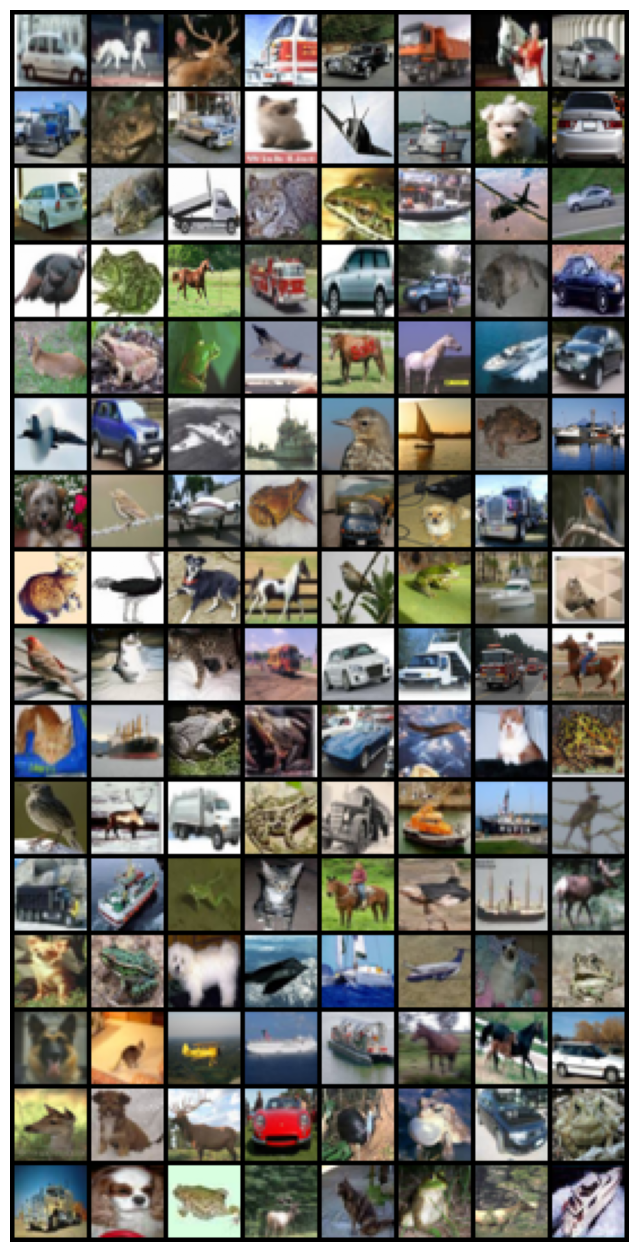

In [4]:
for images, _ in training_dl:
    print('images.shape:', images.shape)
    x = torch.reshape(images, [images.shape[0], -1])
    print("x, x.shape: ", x.shape)
    print('max, min:', torch.max(images), torch.min(images), images.dtype)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

2359296


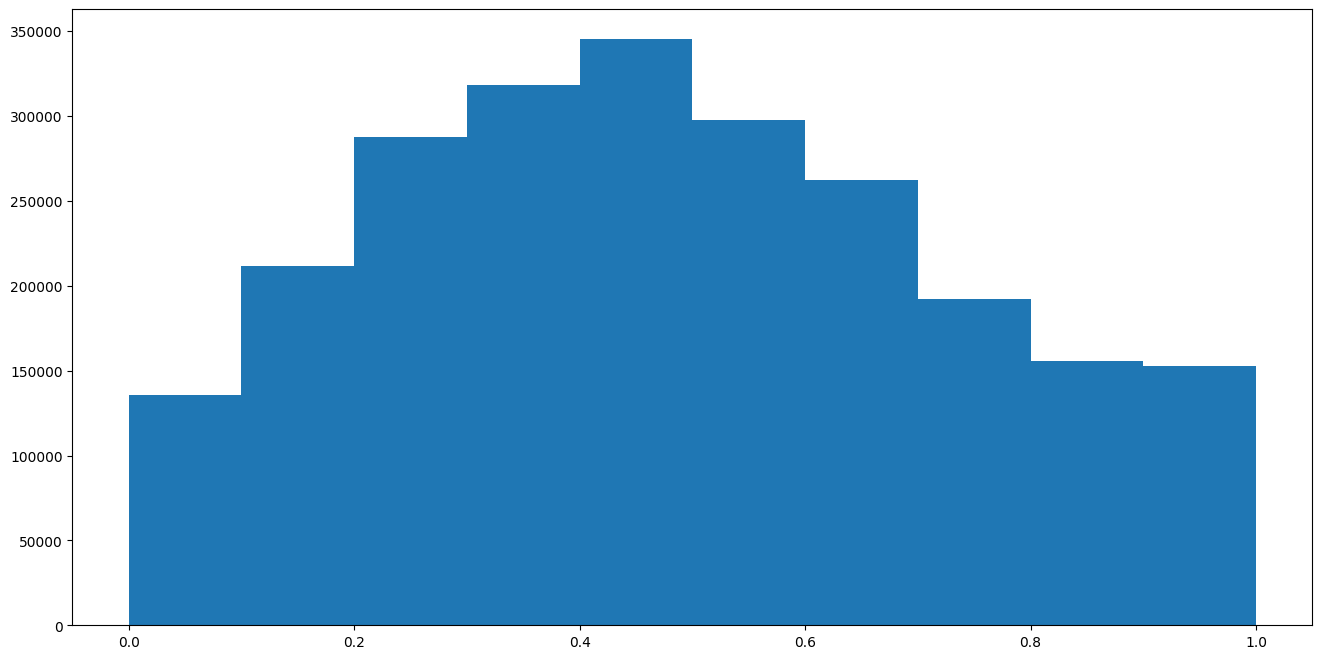

In [5]:
# Plot histogram of pixel value of datasets.
# Use 10 batches
pixels = []
for i, (images, _) in enumerate(training_dl):
    # images = torchvision.transforms.functional.rgb_to_grayscale(images)
    if i > 5:
        break
    pixels.append(images.flatten().cpu().numpy())
pixels = np.concatenate(pixels)
print(len(pixels))
plt.figure(figsize=(16,8))
_ = plt.hist(pixels, bins=10, range=(0.0, 1.0))

plt.show()

In [6]:
def get_device():
    env_device = os.environ.get('TORCH_DEVICE', "")
    print("TORCH_DEVICE: '%s'" % env_device)
    if env_device == "cpu":
        device = torch.device("cpu")
    elif env_device == "mps":
        device = torch.device("mps")
    else:
        device = torch.device("cuda" if torch.cuda.is_available()
                          else "mps" if torch.backends.mps.is_built() else "cpu")  # Select device for inference
    print("device: %s" % device)

    return device

X_DIM = 3*32*32
Z_DIM = 32

class VAENet(torch.nn.Module):
    
    def __init__(self, x_dim, encoder_dims, decoder_dims, z_dim):
        super(VAENet, self).__init__()
        
        # encoder part:
        self.encoder_block = torch.nn.Sequential()
        prev_dim = x_dim
        for dim in encoder_dims:
            self.encoder_block.append(torch.nn.Linear(prev_dim, dim))
            self.encoder_block.append(torch.nn.ReLU())
            prev_dim = dim
            
        self.encoder_last_fc1, self.encoder_last_fc2  = \
            torch.nn.Linear(prev_dim, z_dim), torch.nn.Linear(prev_dim, z_dim)
    
        self.decoder_block = torch.nn.Sequential()
        prev_dim = z_dim
        for dim in decoder_dims:
            self.decoder_block.append(torch.nn.Linear(prev_dim, dim))
            self.decoder_block.append(torch.nn.ReLU())
            prev_dim = dim
        
        self.decoder_last_fc = torch.nn.Linear(prev_dim, x_dim)
    
    def encode(self, x):
        h = self.encoder_block(x)
    
        mu = self.encoder_last_fc1(h)
        log_var = self.encoder_last_fc2(h)
        
        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(mu)
        
        return mu + std*eps
    
    def decode(self, z):
        h = self.decoder_block(z)
        
        return torch.sigmoid(self.decoder_last_fc(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        # rc_x: reconstructed x
        rc_x = self.decode(z)
        #print("mu, log_var, z, rc_x: ", mu.shape, log_var.shape, z.shape, rc_x.shape)
        
        return rc_x, mu, log_var

DEBUG_slot = dict()
def vae_loss_fn(x, rc_x, mu, log_var):
    # log(p(x|z))
    # bce_loss = F.binary_cross_entropy(rc_x, x, reduction="sum")
    # Use mse as reconstructed loss
    rc_loss = F.mse_loss(rc_x, x, reduction="sum")
    DEBUG_slot['x'] = x.cpu()
    DEBUG_slot['rc_x'] = rc_x.cpu()    
    DEBUG_slot['rc_loss'] = rc_loss.cpu()
    
    kld_loss = -0.5*torch.sum(1 + log_var - torch.exp(log_var) - mu*mu)
    DEBUG_slot['mu'] = mu
    DEBUG_slot['log_var'] = log_var
    DEBUG_slot['kld_loss'] = kld_loss
    
    loss = kld_loss + rc_loss
    
    return loss, rc_loss, kld_loss
      

In [7]:
device = get_device()
print("device used: %s" % device)
vae = VAENet(x_dim=X_DIM, encoder_dims=[512, 256, 128, 64], 
             decoder_dims=[64, 128, 256, 512], z_dim=Z_DIM).to(device)
print(vae)
optimizer = torch.optim.Adam(vae.parameters())
#optimizer = torch.optim.SGD(vae.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

print(optimizer)

TORCH_DEVICE: ''
device: cuda
device used: cuda
VAENet(
  (encoder_block): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (encoder_last_fc1): Linear(in_features=64, out_features=32, bias=True)
  (encoder_last_fc2): Linear(in_features=64, out_features=32, bias=True)
  (decoder_block): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
  )
  (decoder_last_fc): Linear(in_features=512, out_features=3072, bias=True)
)
Adam (
Parameter Group 0
    a

In [8]:
def train(epoch):
    vae.train()
    loss_sum = 0.0
    rc_loss_sum = 0.0
    kld_loss_sum = 0.0

    for batch_idx, (x, _) in enumerate(training_dl):
        x = x.to(device)
        x = torch.reshape(x, [-1, X_DIM])
        optimizer.zero_grad()
        
        rc_x, mu, log_var = vae(x)
        loss, rc_loss, kld_loss = vae_loss_fn(x, rc_x, mu, log_var)
        loss.backward()
        loss_sum += loss.item()
        rc_loss_sum += rc_loss.item()
        kld_loss_sum += kld_loss.item()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, RC loss: {:.6f}, KLD loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(training_dl.dataset),
                100. * batch_idx / len(training_dl), 
                loss.item() / len(x), rc_loss.item()/len(x), 
                kld_loss.item()/len(x)))
            
    print('====> Epoch: {} Average loss: {:.4f}, RC loss: {:.4f}, KLD loss: {:.4f}'.format(
        epoch, loss_sum / len(training_dl.dataset), 
        rc_loss_sum / len(training_dl.dataset), 
        kld_loss_sum / len(training_dl.dataset)))

def test():
    vae.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, _ in test_dl:
            x = x.to(device)
            x = torch.reshape(x, [-1, X_DIM])
            rc_x, mu, log_var = vae(x)
            loss_sum += vae_loss_fn(x, rc_x, mu, log_var)[0]
    
    print('====> Test set loss: {:.4f}'.format(loss_sum/len(test_dl.dataset)))

def val():
    vae.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, _ in val_dl:
            x = x.to(device)
            x = torch.reshape(x, [-1, X_DIM])
            rc_x, mu, log_var = vae(x)
            loss_sum += vae_loss_fn(x, rc_x, mu, log_var)[0]
    
    print('====> Validation set loss: {:.4f}'.format(loss_sum/len(val_dl.dataset)))

In [9]:
for epoch in range(1, 200):
    train(epoch)
    val()
test()

Train Epoch: 1 [0/45000 (0%)]	Loss: 185.848373, RC loss: 185.699982, KLD loss: 0.148391
Train Epoch: 1 [25600/45000 (57%)]	Loss: 146.867783, RC loss: 140.729263, KLD loss: 6.138515
====> Epoch: 1 Average loss: 151.8764, RC loss: 145.2986, KLD loss: 6.5778
====> Validation set loss: 129.9019
Train Epoch: 2 [0/45000 (0%)]	Loss: 136.425354, RC loss: 128.184753, KLD loss: 8.240600
Train Epoch: 2 [25600/45000 (57%)]	Loss: 123.537148, RC loss: 117.230942, KLD loss: 6.306205
====> Epoch: 2 Average loss: 123.8484, RC loss: 116.9423, KLD loss: 6.9062
====> Validation set loss: 115.6679
Train Epoch: 3 [0/45000 (0%)]	Loss: 110.764122, RC loss: 103.013283, KLD loss: 7.750842
Train Epoch: 3 [25600/45000 (57%)]	Loss: 119.753815, RC loss: 112.601395, KLD loss: 7.152421
====> Epoch: 3 Average loss: 112.5689, RC loss: 105.1860, KLD loss: 7.3829
====> Validation set loss: 111.7486
Train Epoch: 4 [0/45000 (0%)]	Loss: 116.132599, RC loss: 109.489304, KLD loss: 6.643291
Train Epoch: 4 [25600/45000 (57%)]	L

====> Epoch: 29 Average loss: 93.2883, RC loss: 83.8375, KLD loss: 9.4508
====> Validation set loss: 95.0226
Train Epoch: 30 [0/45000 (0%)]	Loss: 96.481369, RC loss: 87.157219, KLD loss: 9.324150
Train Epoch: 30 [25600/45000 (57%)]	Loss: 97.201691, RC loss: 87.453751, KLD loss: 9.747936
====> Epoch: 30 Average loss: 93.2655, RC loss: 83.8079, KLD loss: 9.4577
====> Validation set loss: 94.5394
Train Epoch: 31 [0/45000 (0%)]	Loss: 90.661224, RC loss: 80.843643, KLD loss: 9.817583
Train Epoch: 31 [25600/45000 (57%)]	Loss: 95.493805, RC loss: 85.906921, KLD loss: 9.586882
====> Epoch: 31 Average loss: 93.3027, RC loss: 83.8277, KLD loss: 9.4750
====> Validation set loss: 94.9975
Train Epoch: 32 [0/45000 (0%)]	Loss: 90.106323, RC loss: 80.166901, KLD loss: 9.939423
Train Epoch: 32 [25600/45000 (57%)]	Loss: 90.992439, RC loss: 81.748009, KLD loss: 9.244429
====> Epoch: 32 Average loss: 92.9624, RC loss: 83.4481, KLD loss: 9.5143
====> Validation set loss: 94.4497
Train Epoch: 33 [0/45000 (0

Train Epoch: 58 [25600/45000 (57%)]	Loss: 84.418785, RC loss: 74.599091, KLD loss: 9.819693
====> Epoch: 58 Average loss: 91.4207, RC loss: 81.5806, KLD loss: 9.8402
====> Validation set loss: 92.9047
Train Epoch: 59 [0/45000 (0%)]	Loss: 88.960854, RC loss: 79.033524, KLD loss: 9.927330
Train Epoch: 59 [25600/45000 (57%)]	Loss: 92.084282, RC loss: 82.621231, KLD loss: 9.463054
====> Epoch: 59 Average loss: 91.5246, RC loss: 81.6851, KLD loss: 9.8395
====> Validation set loss: 93.8271
Train Epoch: 60 [0/45000 (0%)]	Loss: 97.280777, RC loss: 87.447235, KLD loss: 9.833538
Train Epoch: 60 [25600/45000 (57%)]	Loss: 90.416489, RC loss: 80.520096, KLD loss: 9.896393
====> Epoch: 60 Average loss: 91.5368, RC loss: 81.6829, KLD loss: 9.8539
====> Validation set loss: 93.1822
Train Epoch: 61 [0/45000 (0%)]	Loss: 86.521820, RC loss: 76.501373, KLD loss: 10.020445
Train Epoch: 61 [25600/45000 (57%)]	Loss: 92.305756, RC loss: 82.769150, KLD loss: 9.536605
====> Epoch: 61 Average loss: 91.3471, RC l

====> Validation set loss: 93.2933
Train Epoch: 87 [0/45000 (0%)]	Loss: 93.255745, RC loss: 82.984482, KLD loss: 10.271266
Train Epoch: 87 [25600/45000 (57%)]	Loss: 92.099258, RC loss: 82.466965, KLD loss: 9.632290
====> Epoch: 87 Average loss: 90.8161, RC loss: 80.8263, KLD loss: 9.9898
====> Validation set loss: 94.4150
Train Epoch: 88 [0/45000 (0%)]	Loss: 89.520004, RC loss: 79.658302, KLD loss: 9.861698
Train Epoch: 88 [25600/45000 (57%)]	Loss: 92.125923, RC loss: 82.215889, KLD loss: 9.910036
====> Epoch: 88 Average loss: 90.8932, RC loss: 80.9081, KLD loss: 9.9850
====> Validation set loss: 93.3980
Train Epoch: 89 [0/45000 (0%)]	Loss: 82.797562, RC loss: 72.884346, KLD loss: 9.913212
Train Epoch: 89 [25600/45000 (57%)]	Loss: 85.093018, RC loss: 75.086456, KLD loss: 10.006563
====> Epoch: 89 Average loss: 90.6537, RC loss: 80.6144, KLD loss: 10.0393
====> Validation set loss: 92.7202
Train Epoch: 90 [0/45000 (0%)]	Loss: 102.490158, RC loss: 91.932770, KLD loss: 10.557386
Train Epo

Train Epoch: 115 [0/45000 (0%)]	Loss: 87.207283, RC loss: 77.020393, KLD loss: 10.186892
Train Epoch: 115 [25600/45000 (57%)]	Loss: 91.335503, RC loss: 81.319008, KLD loss: 10.016497
====> Epoch: 115 Average loss: 90.2189, RC loss: 80.0793, KLD loss: 10.1397
====> Validation set loss: 92.9305
Train Epoch: 116 [0/45000 (0%)]	Loss: 88.275024, RC loss: 78.146233, KLD loss: 10.128795
Train Epoch: 116 [25600/45000 (57%)]	Loss: 90.597694, RC loss: 80.605011, KLD loss: 9.992686
====> Epoch: 116 Average loss: 90.4305, RC loss: 80.3052, KLD loss: 10.1253
====> Validation set loss: 93.3203
Train Epoch: 117 [0/45000 (0%)]	Loss: 89.673317, RC loss: 79.351631, KLD loss: 10.321686
Train Epoch: 117 [25600/45000 (57%)]	Loss: 89.873009, RC loss: 79.823608, KLD loss: 10.049400
====> Epoch: 117 Average loss: 90.3889, RC loss: 80.2349, KLD loss: 10.1540
====> Validation set loss: 93.2903
Train Epoch: 118 [0/45000 (0%)]	Loss: 98.047867, RC loss: 87.921967, KLD loss: 10.125898
Train Epoch: 118 [25600/45000 

Train Epoch: 143 [0/45000 (0%)]	Loss: 91.767464, RC loss: 80.992935, KLD loss: 10.774526
Train Epoch: 143 [25600/45000 (57%)]	Loss: 97.647995, RC loss: 87.373817, KLD loss: 10.274174
====> Epoch: 143 Average loss: 90.6672, RC loss: 80.4617, KLD loss: 10.2055
====> Validation set loss: 93.3477
Train Epoch: 144 [0/45000 (0%)]	Loss: 91.472321, RC loss: 81.303207, KLD loss: 10.169111
Train Epoch: 144 [25600/45000 (57%)]	Loss: 96.949615, RC loss: 86.849869, KLD loss: 10.099743
====> Epoch: 144 Average loss: 90.5076, RC loss: 80.3212, KLD loss: 10.1864
====> Validation set loss: 94.3230
Train Epoch: 145 [0/45000 (0%)]	Loss: 86.006088, RC loss: 75.953171, KLD loss: 10.052919
Train Epoch: 145 [25600/45000 (57%)]	Loss: 92.193466, RC loss: 81.896706, KLD loss: 10.296761
====> Epoch: 145 Average loss: 91.3453, RC loss: 81.1641, KLD loss: 10.1812
====> Validation set loss: 93.8953
Train Epoch: 146 [0/45000 (0%)]	Loss: 91.460243, RC loss: 81.098297, KLD loss: 10.361948
Train Epoch: 146 [25600/45000

Train Epoch: 171 [0/45000 (0%)]	Loss: 94.984955, RC loss: 84.397949, KLD loss: 10.587002
Train Epoch: 171 [25600/45000 (57%)]	Loss: 90.791565, RC loss: 80.939095, KLD loss: 9.852470
====> Epoch: 171 Average loss: 89.4801, RC loss: 79.1537, KLD loss: 10.3264
====> Validation set loss: 92.8471
Train Epoch: 172 [0/45000 (0%)]	Loss: 90.327286, RC loss: 79.694344, KLD loss: 10.632944
Train Epoch: 172 [25600/45000 (57%)]	Loss: 91.623764, RC loss: 81.469086, KLD loss: 10.154678
====> Epoch: 172 Average loss: 90.0220, RC loss: 79.7070, KLD loss: 10.3150
====> Validation set loss: 93.5498
Train Epoch: 173 [0/45000 (0%)]	Loss: 90.518852, RC loss: 79.900360, KLD loss: 10.618494
Train Epoch: 173 [25600/45000 (57%)]	Loss: 91.003105, RC loss: 80.660965, KLD loss: 10.342142
====> Epoch: 173 Average loss: 90.2975, RC loss: 80.0752, KLD loss: 10.2224
====> Validation set loss: 93.1510
Train Epoch: 174 [0/45000 (0%)]	Loss: 88.516258, RC loss: 78.290047, KLD loss: 10.226210
Train Epoch: 174 [25600/45000 

Train Epoch: 199 [0/45000 (0%)]	Loss: 86.836082, RC loss: 76.650024, KLD loss: 10.186060
Train Epoch: 199 [25600/45000 (57%)]	Loss: 91.299965, RC loss: 81.112785, KLD loss: 10.187181
====> Epoch: 199 Average loss: 89.6740, RC loss: 79.3466, KLD loss: 10.3274
====> Validation set loss: 94.9141
====> Test set loss: 94.1591


tensor(0.9949) tensor(0.0050)
torch.Size([64, 3, 32, 32])


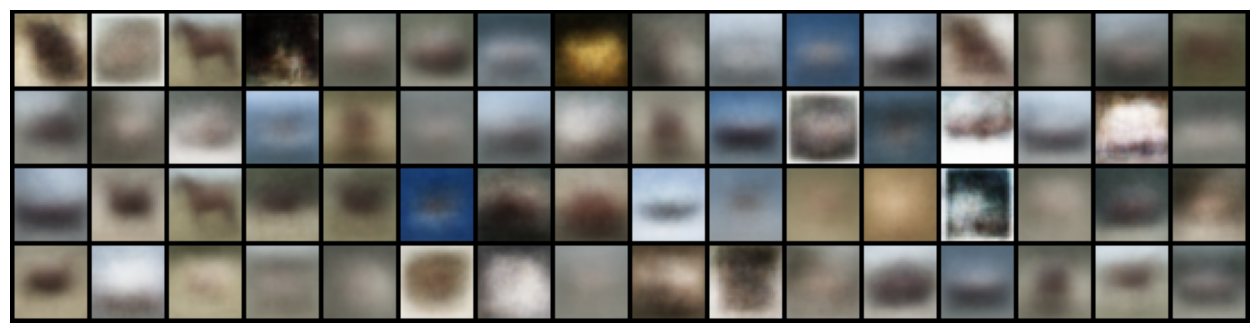

In [10]:
with torch.no_grad():
    z = torch.randn(64, Z_DIM).to(device)
    image_samples = vae.decode(z).cpu()
    print(torch.max(image_samples), torch.min(image_samples))
    image_samples = image_samples.reshape(64, 3, 32, 32)
    print(image_samples.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image_samples, nrow=16).permute(1, 2, 0))    

In [11]:
DEBUG_slot['mu'].shape, DEBUG_slot['log_var'].shape

(torch.Size([16, 32]), torch.Size([16, 32]))

tensor(0.9456) tensor(0.0445)
torch.Size([16, 3, 32, 32])


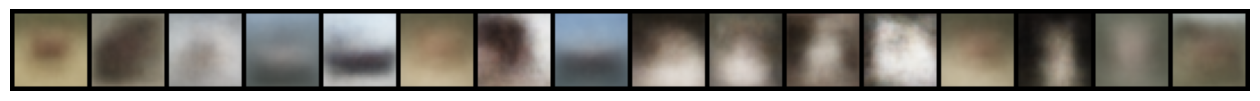

In [12]:
with torch.no_grad():
    #z = torch.randn(64, Z_DIM).to(device)
    z = vae.sampling(DEBUG_slot['mu'], DEBUG_slot['log_var'])
    image_samples = vae.decode(z).cpu()
    print(torch.max(image_samples), torch.min(image_samples))
    image_samples = image_samples.reshape(z.shape[0], 3, 32, 32)
    print(image_samples.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image_samples, nrow=16).permute(1, 2, 0))    